In [ ]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

In [ ]:
from pyomo.environ import *
from pyomo.dae import *
import matplotlib.pyplot as plt
import random
import math

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

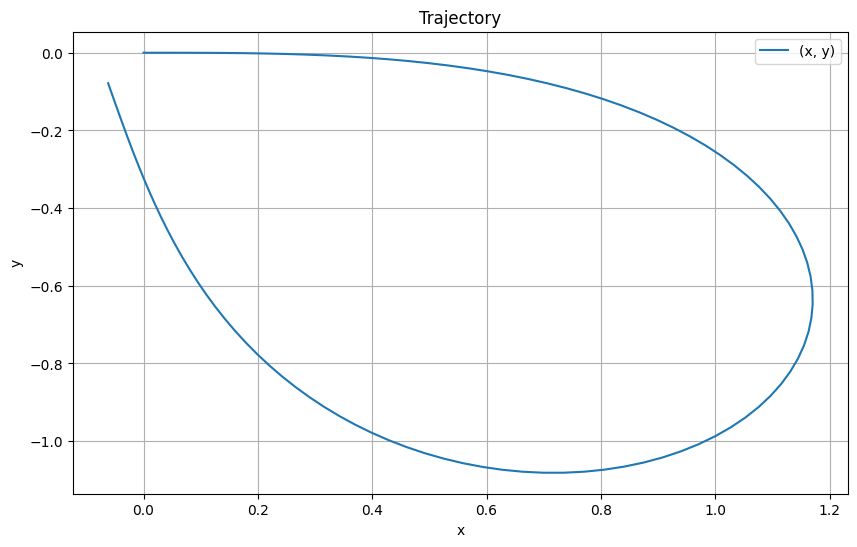

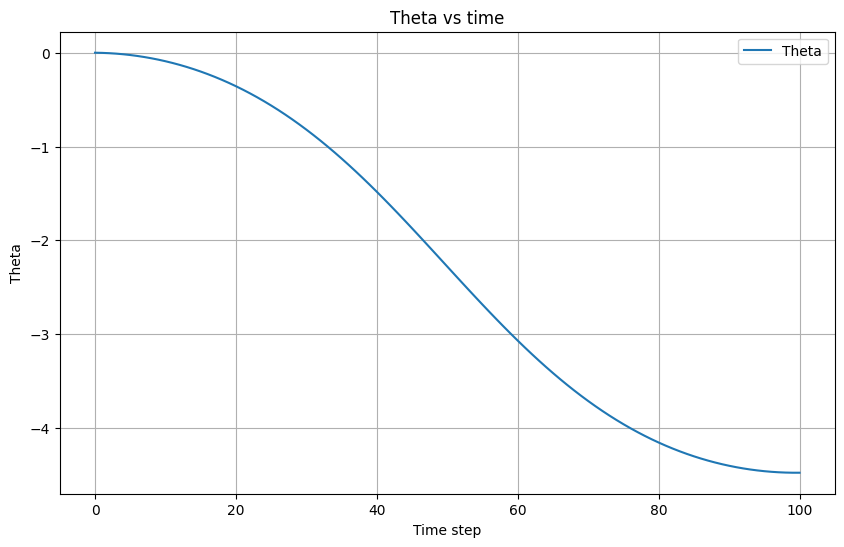

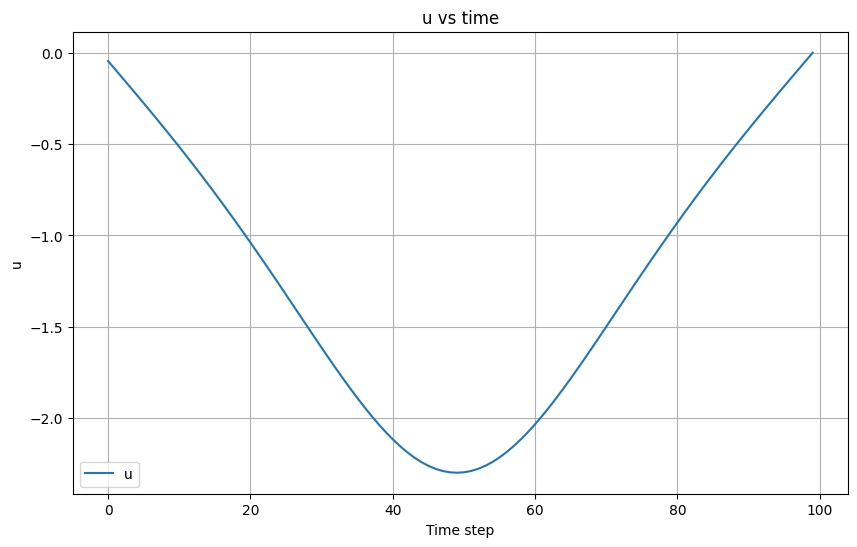

In [ ]:
N = 100
delta_tau = 1 / N

model = ConcreteModel()

# Time steps
model.T = RangeSet(0, N)

# DVs
model.t_f = Var(within=NonNegativeReals)
# test
#model.t_f.fix(1.0)

model.x = Var(model.T)
model.y = Var(model.T)
model.theta = Var(model.T)
model.u = Var(model.T, within=Reals, bounds=(-6, 6))

for t in model.T:
  model.x[t].set_value(10)
  model.y[t].set_value(10)
  model.theta[t].set_value(0.0)
  if t < N:
      model.u[t].set_value(0)

# Objective
model.objective = Objective(
    expr = model.t_f * sum((1 + 0.5 * model.u[t]**2) * delta_tau for t in model.T),
    sense=minimize
)

# Initial conditions
model.x[0].fix(0)
model.y[0].fix(0)
model.theta[0].fix(0)

# Dynamics constraints w/ Forward Euler
def x_dyn_rule(model, t):
    if t == 0:
        return Constraint.Skip
    return model.x[t] == model.x[t - 1] + model.t_f * cos(model.theta[t - 1]) * delta_tau

model.x_dyn = Constraint(model.T, rule=x_dyn_rule)

def y_dyn_rule(model, t):
    if t == 0:
        return Constraint.Skip
    return model.y[t] == model.y[t - 1] + model.t_f * sin(model.theta[t - 1]) * delta_tau

model.y_dyn = Constraint(model.T, rule=y_dyn_rule)

def theta_dyn_rule(model, t):
    if t == 0:
        return Constraint.Skip
    return model.theta[t] == model.theta[t - 1] + model.t_f * model.u[t - 1] * delta_tau

model.theta_dyn = Constraint(model.T, rule=theta_dyn_rule)

# Boundary conditions
model.terminal_constraint = Constraint(
    expr=model.x[N]**2 + model.y[N]**2 <= (0.1)**2
)

# Solve the model with the fixed t_f
solver = SolverFactory('ipopt')
solver.solve(model, tee=True)

# Plot values
time_steps = range(N + 1)
x_values = [model.x[t].value for t in time_steps]
y_values = [model.y[t].value for t in time_steps]
theta_values = [model.theta[t].value for t in time_steps]
u_values = [model.u[t].value for t in time_steps[:-1]]

# Trajectory
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory')
plt.legend()
plt.grid()

# Theta vs time
plt.figure(figsize=(10, 6))
plt.plot(time_steps, theta_values, label='Theta')
plt.xlabel('Time step')
plt.ylabel('Theta')
plt.title('Theta vs time')
plt.legend()
plt.grid()

# u vs time
plt.figure(figsize=(10, 6))
plt.plot(time_steps[:-1], u_values, label='u')
plt.xlabel('Time step')
plt.ylabel('u')
plt.title('u vs time')
plt.legend()
plt.grid()

plt.show()